In [45]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split
from data_reader import read_consumption_and_weather
from sklearn.preprocessing import MinMaxScaler

In [46]:
def plot_losses(tr, va):
  import matplotlib.pyplot as plt
  fig, ax = plt.subplots()
  ax.plot(tr, label='train')
  ax.plot(va, label='validation')
  ax.legend()
  plt.show()

In [47]:
df = read_consumption_and_weather()[-1]

df_no1 = df['NO1']
df_no1.loc[:,'region'] = 1

df_no2 = df['NO2']
df_no2.loc[:,'region'] = 2

df_no3 = df['NO3']
df_no3.loc[:,'region'] = 3

df_no4 = df['NO4']
df_no4.loc[:,'region'] = 4

df_no5 = df['NO5']
df_no5.loc[:,'region'] = 5

# combine all dataframes into one
df = pd.concat([df_no1, df_no2, df_no3, df_no4, df_no5])


# datetime features
dates = df.index
df['time_of_day'] = df.index.hour
df['time_of_week'] = df.index.dayofweek
df['time_of_month'] = df.index.day
df['time_of_year'] = df.index.month

df.head()


Holes by length and occurrences in column NO3:
Filling holes up to length 3
Any remaining holes after interpolation? False


/usr/lib/python3/dist-packages/pandas/core/indexing.py:376: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/usr/lib/python3/dist-packages/pandas/core/indexing.py:576: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item_labels[indexer[info_axis]]] = value


,consumption,temperature,region,time_of_day,time_of_week,time_of_month,time_of_year
2017-05-01 00:00:00+00:00,3325.431995,2.2,1,0,0,1,5
2017-05-01 01:00:00+00:00,3344.690998,3.2,1,1,0,1,5
2017-05-01 02:00:00+00:00,3398.359002,4.0,1,2,0,1,5
2017-05-01 03:00:00+00:00,3430.220001,3.6,1,3,0,1,5
2017-05-01 04:00:00+00:00,3606.750000,3.4,1,4,0,1,5


In [48]:
df['consumption_24h_lag'] = df['consumption'].shift(24)#fillna(method='bfill')
df = df.dropna()
df['consumption_yday_mean'] = df['consumption'].shift(24).rolling(24).mean()#fillna(method='bfill')
df = df.dropna()
df['consumption_prev'] = df['consumption'].shift(1)#fillna(method='bfill')
df = df.dropna()
df.head()

,consumption,temperature,region,time_of_day,time_of_week,time_of_month,time_of_year,consumption_24h_lag,consumption_yday_mean,consumption_prev
2017-05-04 00:00:00+00:00,2729.629003,9.5,1,0,3,4,5,2870.407999,3623.894460,2776.312998
2017-05-04 01:00:00+00:00,2782.087997,9.3,1,1,3,4,5,2885.274001,3608.622501,2729.629003
2017-05-04 02:00:00+00:00,2825.548003,7.9,1,2,3,4,5,2887.499001,3590.076751,2782.087997
2017-05-04 03:00:00+00:00,2951.974004,7.2,1,3,3,4,5,2951.849002,3567.845918,2825.548003
2017-05-04 04:00:00+00:00,3426.861001,6.4,1,4,3,4,5,3416.992002,3543.477001,2951.974004


In [49]:
# df = pd.read_csv('data/clean.csv', index_col=0)
# df.index = pd.to_datetime(df.index)
# df = df[['region', 'temperature', 'consumption']]
# df = df[[ 'consumption']]
# df.head()

In [50]:
df = df[['consumption', 'temperature']]
df.head()

,consumption,temperature
2017-05-04 00:00:00+00:00,2729.629003,9.5
2017-05-04 01:00:00+00:00,2782.087997,9.3
2017-05-04 02:00:00+00:00,2825.548003,7.9
2017-05-04 03:00:00+00:00,2951.974004,7.2
2017-05-04 04:00:00+00:00,3426.861001,6.4


In [51]:
scaler = MinMaxScaler(feature_range=(-1, 1))
# scale temperature and consumption
df[['temperature', 'consumption']] = scaler.fit_transform(df[['temperature', 'consumption']])
#df[['consumption']] = scaler.fit_transform(df[['consumption']])
df.head()

,consumption,temperature
2017-05-04 00:00:00+00:00,-0.498429,0.117021
2017-05-04 01:00:00+00:00,-0.483310,0.109929
2017-05-04 02:00:00+00:00,-0.470784,0.060284
2017-05-04 03:00:00+00:00,-0.434346,0.035461
2017-05-04 04:00:00+00:00,-0.297478,0.007092


In [52]:
# Defining a function that creates sequences and targets as shown above
def generate_sequences(df: pd.DataFrame, tw: int, pw: int, target_columns, drop_targets=False):
  '''
  df: Pandas DataFrame of the univariate time-series
  tw: Training Window - Integer defining how many steps to look back
  pw: Prediction Window - Integer defining how many steps forward to predict

  returns: dictionary of sequences and targets for all sequences
  '''
  data = dict() # Store results into a dictionary
  L = len(df)
  for i in range(L-tw):
    # Option to drop target from dataframe
    if drop_targets:
      df.drop(target_columns, axis=1, inplace=True)

    # Get current sequence  
    sequence = df[i:i+tw].values
    # Get values right after the current sequence
    target = df[i+tw:i+tw+pw][target_columns].values
    data[i] = {'sequence': sequence, 'target': target}
  return data

In [53]:
class SequenceDataset(Dataset):

  def __init__(self, df):
    self.data = df

  def __getitem__(self, idx):
    sample = self.data[idx]
    return torch.Tensor(sample['sequence']), torch.Tensor(sample['target'])
  
  def __len__(self):
    return len(self.data)

In [54]:
BATCH_SIZE = 16
sequence_len = 24
split = 0.8
n_out = 1

sequences = generate_sequences(df, sequence_len, n_out, 'consumption')
dataset = SequenceDataset(sequences)

In [55]:
sequences[0]

{'sequence': array([[-0.49842886,  0.11702128],
        [-0.48330953,  0.10992908],
        [-0.47078381,  0.06028369],
        [-0.43434626,  0.03546099],
        [-0.29747789,  0.0070922 ],
        [-0.15560414,  0.05319149],
        [-0.13436864,  0.10283688],
        [-0.16366717,  0.12056738],
        [-0.1841487 ,  0.15248227],
        [-0.19880114,  0.20212766],
        [-0.20047508,  0.22695035],
        [-0.23178245,  0.26950355],
        [-0.24709258,  0.30851064],
        [-0.2646332 ,  0.32624113],
        [-0.26764674,  0.34397163],
        [-0.27949112,  0.32269504],
        [-0.2993164 ,  0.32269504],
        [-0.30505817,  0.33687943],
        [-0.30101339,  0.30851064],
        [-0.28351169,  0.24468085],
        [-0.29736722,  0.18794326],
        [-0.36675495,  0.17021277],
        [-0.43152408,  0.15248227],
        [-0.46556313,  0.14539007]]),
 'target': array([-0.48197741])}

In [56]:

train_len = int(len(dataset)*split)
lens = [train_len, len(dataset)-train_len]
train_ds, test_ds = random_split(dataset, lens)
trainloader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)
testloader = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)

In [57]:
x, y = next(iter(trainloader))
x.shape, y.shape

(torch.Size([16, 24, 2]), torch.Size([16, 1]))

In [58]:
class LSTMForecaster(nn.Module):


  def __init__(self, n_features, n_hidden, n_outputs, sequence_len, n_lstm_layers=1, n_deep_layers=10, use_cuda=False, dropout=0.2):
    '''
    n_features: number of input features (1 for univariate forecasting)
    n_hidden: number of neurons in each hidden layer
    n_outputs: number of outputs to predict for each training example
    n_deep_layers: number of hidden dense layers after the lstm layer
    sequence_len: number of steps to look back at for prediction
    dropout: float (0 < dropout < 1) dropout ratio between dense layers
    '''
    super().__init__()

    self.n_lstm_layers = n_lstm_layers
    self.nhid = n_hidden
    self.use_cuda = use_cuda # set option for device selection

    # LSTM Layer
    self.lstm = nn.LSTM(n_features,
                        n_hidden,
                        num_layers=n_lstm_layers,
                        batch_first=True) # As we have transformed our data in this way
    
    # first dense after lstm
    self.fc1 = nn.Linear(n_hidden * sequence_len, n_hidden) 
    # Dropout layer 
    self.dropout = nn.Dropout(p=dropout)

    # Create fully connected layers (n_hidden x n_deep_layers)
    dnn_layers = []
    for i in range(n_deep_layers):
      # Last layer (n_hidden x n_outputs)
      if i == n_deep_layers - 1:
        dnn_layers.append(nn.ReLU())
        dnn_layers.append(nn.Linear(nhid, n_outputs))
      # All other layers (n_hidden x n_hidden) with dropout option
      else:
        dnn_layers.append(nn.ReLU())
        dnn_layers.append(nn.Linear(nhid, nhid))
        if dropout:
          dnn_layers.append(nn.Dropout(p=dropout))
    # compile DNN layers
    self.dnn = nn.Sequential(*dnn_layers)

  def forward(self, x):

    # Initialize hidden state
    hidden_state = torch.zeros(self.n_lstm_layers, x.shape[0], self.nhid)
    cell_state = torch.zeros(self.n_lstm_layers, x.shape[0], self.nhid)

    # move hidden state to device
    if self.use_cuda:
      hidden_state = hidden_state.to(device)
      cell_state = cell_state.to(device)
        
    self.hidden = (hidden_state, cell_state)

    # Forward Pass
    x, h = self.lstm(x, self.hidden) # LSTM
    x = self.dropout(x.contiguous().view(x.shape[0], -1)) # Flatten lstm out 
    x = self.fc1(x) # First Dense
    return self.dnn(x) # Pass forward through fully connected DNN.

In [61]:
nhid = 50
n_dnn_layers = 2
#ninp = 1
ninp = 2
USE_CUDA = torch.cuda.is_available()
device = 'cuda' if USE_CUDA else 'cpu'
lr = 4e-4
n_epochs = 5

model = LSTMForecaster(ninp, nhid, n_out, sequence_len, n_deep_layers=n_dnn_layers, use_cuda=USE_CUDA).to(device)
criterion = nn.MSELoss().to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=lr)

0 - train: 0.0037293027274450897, valid: 0.00037463236607348393
1 - train: 0.001990349704448676, valid: 0.0002852104286740096
2 - train: 0.0018605521184022272, valid: 0.00021487429239177615
3 - train: 0.0018144003887007106, valid: 0.0002283110027802854
4 - train: 0.0017693783169192314, valid: 0.00026558719758199635


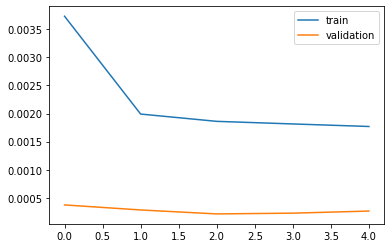

In [62]:
t_losses, v_losses = [], []

best_loss = float('inf')
last_improvement = 0
patience = 2

for epoch in range(n_epochs):
  train_loss, valid_loss = 0.0, 0.0

  # train step
  model.train()
  for x, y in trainloader:
    optimizer.zero_grad()
    x = x.to(device)
    y  = y.squeeze().to(device)
    # Forward Pass
    preds = model(x).squeeze()
    
    loss = criterion(preds, y)
    train_loss += loss.item()
    loss.backward()
    optimizer.step()
  epoch_loss = train_loss / len(trainloader)
  t_losses.append(epoch_loss)
  
  # validation step
  model.eval()
  for x, y in testloader:
    with torch.no_grad():
      x, y = x.to(device), y.squeeze().to(device)
      preds = model(x).squeeze()
      error = criterion(preds, y)
    valid_loss += error.item()
  valid_loss = valid_loss / len(testloader)
  v_losses.append(valid_loss)

  if valid_loss < best_loss:
        best_loss = valid_loss
        torch.save(model.state_dict(), 'best_model.pt')
        last_improvement = epoch
  elif epoch - last_improvement > patience:
      print("Validation loss hasn't improved in {} epochs, stopping training".format(patience))
      break
      
  print(f'{epoch} - train: {epoch_loss}, valid: {valid_loss}')
plot_losses(t_losses, v_losses)

In [63]:
def make_predictions_from_dataloader(model, dataloader):
  model.eval()
  predictions, actuals = [], []
  for x, y in dataloader:
    x = x.to(device)
    with torch.no_grad():
      p = model(x)
      predictions.append(p)
      actuals.append(y.squeeze())
  predictions = torch.cat(predictions).cpu().numpy()
  actuals = torch.cat(actuals).numpy()
  return predictions.squeeze(), actuals

In [64]:
unshuffled_dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=False, drop_last=True)
P, Y = make_predictions_from_dataloader(model, unshuffled_dataloader)
P.shape, Y.shape

((250944,), (250944,))

In [65]:
# import plotly.express as px
# pdf = pd.DataFrame([P, Y], index=['predictions', 'actuals']).T

# fig = px.line(pdf)
# fig.update_layout(
#     autosize=False,
#     width=2400,
#     height=800,)
# fig.show()

In [96]:
import torch
import plotly.graph_objects as go

class Forecaster:

  def __init__(self, model, data, target, tw):
    if USE_CUDA:
      self.model = model.to('cuda')
    else:
      self.model = model
    self.data = data
    self.tw = tw
    self.target = target

  def plot_forecast(self, history):
    fig = go.Figure()
    # Add traces
    fig.add_trace(go.Scatter(x=history.index, y=history.actual,
                        mode='lines',
                        name='actual'))
    fig.add_trace(go.Scatter(x=history.index, y=history.forecast,
                        mode='lines',
                        name='forecast'))
    fig.update_layout(
    autosize=False,
    width=2400,
    height=800,)
    fig.show()
  
  def one_step_forecast(self, history):
      '''
      history: a sequence of values representing the latest values of the time 
      series, requirement -> len(history.shape) == 2

      outputs a single value which is the prediction of the next value in the
      sequence.
      '''
      self.model.eval()
      with torch.no_grad():
        pre = torch.Tensor(history).unsqueeze(0)
        #device = next(self.model.parameters()).device  # get device from model parameters
        pre = pre.to(device)  # move input tensor to same device as model
        pred = self.model(pre)
        print(pred.shape)
      return pred.detach().cpu().numpy().reshape(-1)

  def n_step_forecast(self, n: int, forecast_from: int=None, plot=False):
      '''
      n: integer defining how many steps to forecast
      forecast_from: integer defining which index to forecast from. None if
      you want to forecast from the end.
      plot: True if you want to output a plot of the forecast, False if not.
      '''
      history = self.data[self.target].to_frame()
      
      # Create initial sequence input based on where in the series to forecast 
      # from.
      if forecast_from:
        pre = list(history[forecast_from - self.tw : forecast_from][self.target].values)
      else:
        pre = list(history[self.target])[-self.tw:]

      # Call one_step_forecast n times and append prediction to history
      for i, step in enumerate(range(n)):
        pre_ = np.array(pre[-self.tw:]).reshape(-1, 1)
        forecast = self.one_step_forecast(pre_).squeeze()
        pre.append(forecast)

      res = history.copy()
      ls = [np.nan for i in range(len(history))]

      # Note: I have not handled the edge case where the start index + n crosses
      # the end of the dataset
      if forecast_from:
        ls[forecast_from : forecast_from + n] = list(np.array(pre[-n:]))
        res['forecast'] = ls
        res.columns = ['actual', 'forecast']
      else:
        fc = ls + list(np.array(pre[-n:]))
        ls = ls + [np.nan for i in range(len(pre[-n:]))]
        ls[:len(history)] = history[self.target].values
        res = pd.DataFrame([ls, fc], index=['actual', 'forecast']).T

      if plot:
        self.plot_forecast(res)
      return res


In [121]:
fc = Forecaster(model, df, 'consumption', 24)

In [122]:
history = fc.n_step_forecast(n=24, forecast_from=df.__len__()-1000, plot=False)

[[-0.59169758 -0.45035461 -0.57953639 -0.43262411 -0.57651092 -0.42907801
  -0.57936048 -0.39716312 -0.58237527 -0.34751773 -0.58141099 -0.32978723
  -0.57364377 -0.30851064 -0.56747962 -0.29432624 -0.56668964 -0.28368794
  -0.5702858  -0.30851064 -0.57887848 -0.30141844 -0.59306399 -0.29078014
  -0.60791415 -0.31205674 -0.61895972 -0.31205674 -0.6310729  -0.29787234
  -0.64220099 -0.30141844 -0.66105234 -0.29432624 -0.67112597 -0.30141844
  -0.67420045 -0.29432624 -0.6772138  -0.29787234 -0.67725952 -0.31560284
  -0.67482708 -0.31914894 -0.66862097 -0.34397163 -0.65707729 -0.34042553]]


IndexError: too many indices for array: array is 2-dimensional, but 3 were indexed

In [ ]:
history.isna().sum()

actual           0
forecast    250944
dtype: int64

In [ ]:
# remove duplicates from history
#history = history[~history.index.duplicated(keep='first')]

/usr/lib/python3/dist-packages/pandas/core/arrays/datetimes.py:1266: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  warnings.warn(


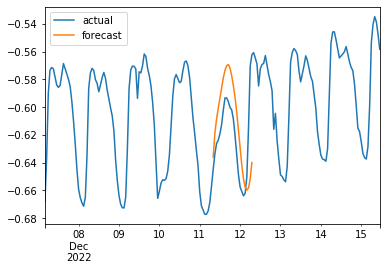

In [ ]:
# plot the last 96 hours
history[-1100:-900].plot()